In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    fbeta_score,
    precision_score, 
    recall_score,
    classification_report
)

# Deep learning
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Visualization
import matplotlib.pyplot as plt

# Data loading
import kagglehub
import os

# handle warnings
import warnings
warnings.filterwarnings("ignore")


# Introduction

In this notebook, we will use TabNet to detect credit card fraud.

TabNet is a deep learning model that is interpretable. Unlike traditional deep learning models, TabNet uses sequential attention to choose which features to reason from at each decision step, enabling interpretability and more efficient learning as the learning capacity is used for the most salient features. (Read the the original [TabNet paper](https://arxiv.org/abs/1908.07442))

We will use the credit card fraud dataset from Kaggle (more details in project ReadMe). 


In [8]:
# Download latest version of the credit card fraud dataset
folder_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file_path = os.path.join(folder_path, "creditcard.csv")

# Read the CSV
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Prepare the data
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TabNet
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',
    lambda_sparse=1e-3
)

# Train the model
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    max_epochs=100,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    eval_metric=['auc']
)

epoch 0  | loss: 0.03182 | val_0_auc: 0.9201  |  0:00:14s
epoch 1  | loss: 0.00665 | val_0_auc: 0.9295  |  0:00:28s
epoch 2  | loss: 0.00531 | val_0_auc: 0.93975 |  0:00:41s
epoch 3  | loss: 0.0049  | val_0_auc: 0.95222 |  0:00:54s
epoch 4  | loss: 0.00467 | val_0_auc: 0.95734 |  0:01:08s
epoch 5  | loss: 0.00443 | val_0_auc: 0.9612  |  0:01:22s
epoch 6  | loss: 0.00446 | val_0_auc: 0.95446 |  0:01:40s
epoch 7  | loss: 0.00449 | val_0_auc: 0.97556 |  0:02:07s
epoch 8  | loss: 0.00422 | val_0_auc: 0.96572 |  0:02:34s
epoch 9  | loss: 0.00414 | val_0_auc: 0.97481 |  0:02:59s
epoch 10 | loss: 0.00413 | val_0_auc: 0.969   |  0:03:19s
epoch 11 | loss: 0.00402 | val_0_auc: 0.94737 |  0:03:33s
epoch 12 | loss: 0.00394 | val_0_auc: 0.96219 |  0:03:45s

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.97556


# Find the optimal threshold

For creditcard fraud detection, the cost of a false positive (i.e., a customer being requeste to verify their account before a transaction is approved) is much lower than the cost of a false negative (i.e., a fraud case being missed). Therefore, in the trade-off between precision and recall, we should prioritize recall. In the code below, we will use F-beta score with beta = 1.5 to boost recall while not penalizing precision too much.

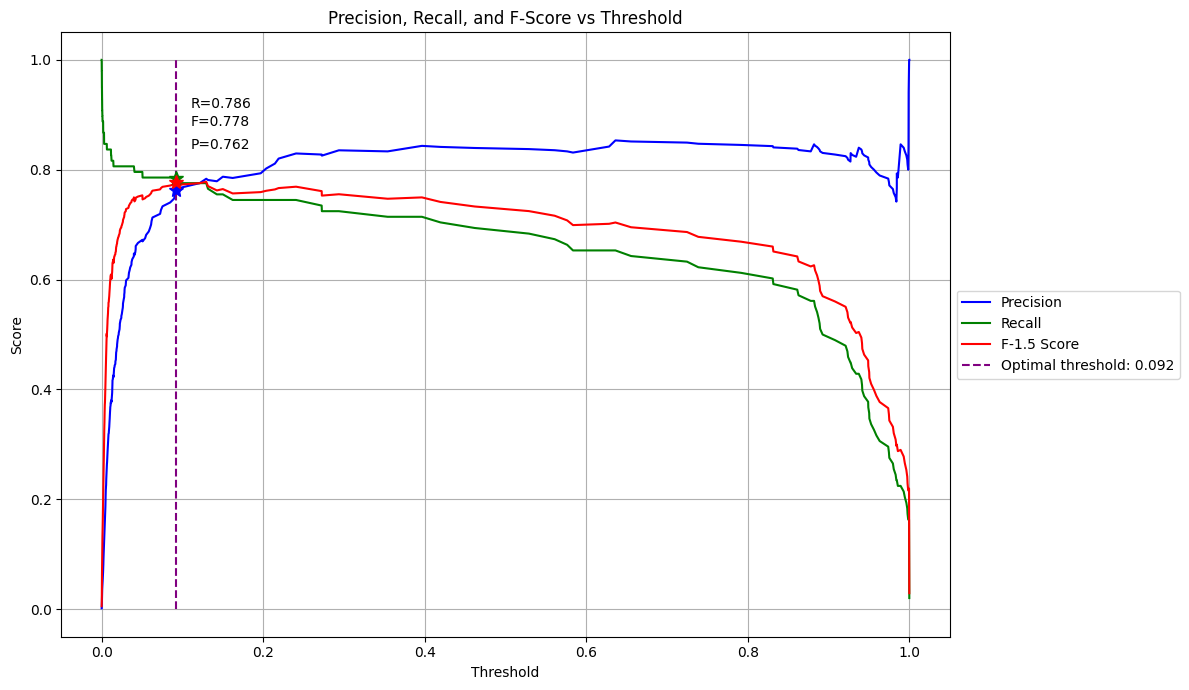


At optimal threshold 0.092:
Precision: 0.762
Recall: 0.786
F-1.5 Score: 0.778


In [4]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_pred_proba = clf.predict_proba(X_test.values)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F-beta scores for these thresholds
beta = 1.5
f_scores = []
for p, r in zip(precision, recall):
    if p == 0 and r == 0:
        f_scores.append(0)
    else:
        f_score = (1 + beta**2) * (p * r) / ((beta**2 * p) + r)
        f_scores.append(f_score)

# Find optimal threshold
optimal_idx = np.argmax(f_scores)
optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else 1.0

# Plot all metrics
plt.figure(figsize=(12, 7))
plt.plot(pr_thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(pr_thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(pr_thresholds, f_scores[:-1], 'r-', label=f'F-{beta} Score')

# Add vertical line for optimal threshold
plt.vlines(optimal_threshold, 0, 1, colors='purple', linestyles='dashed', 
          label=f'Optimal threshold: {optimal_threshold:.3f}')

# Add metrics values at optimal threshold
opt_precision = precision[optimal_idx]
opt_recall = recall[optimal_idx]
opt_fscore = f_scores[optimal_idx]

plt.plot(optimal_threshold, opt_precision, 'b*', markersize=10)
plt.plot(optimal_threshold, opt_recall, 'g*', markersize=10)
plt.plot(optimal_threshold, opt_fscore, 'r*', markersize=10)

# Adjust annotation positions to prevent overlap
plt.annotate(f'P={opt_precision:.3f}', 
            (optimal_threshold, opt_precision),
            xytext=(10, 30), textcoords='offset points')
plt.annotate(f'F={opt_fscore:.3f}', 
            (optimal_threshold, opt_fscore),
            xytext=(10, 40), textcoords='offset points')
plt.annotate(f'R={opt_recall:.3f}', 
            (optimal_threshold, opt_recall),
            xytext=(10, 50), textcoords='offset points')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F-Score vs Threshold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print optimal values
print(f"\nAt optimal threshold {optimal_threshold:.3f}:")
print(f"Precision: {opt_precision:.3f}")
print(f"Recall: {opt_recall:.3f}")
print(f"F-{beta} Score: {opt_fscore:.3f}")

In [5]:
# Compare with default threshold (0.5)
y_pred_default = (y_pred_proba >= 0.5).astype(int)
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Print results for both thresholds
from sklearn.metrics import classification_report

print("With default threshold (0.5):")
print(classification_report(y_test, y_pred_default))

print("\nWith optimal threshold (0.092):")
print(classification_report(y_test, y_pred_optimal))

With default threshold (0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.68      0.75        98

    accuracy                           1.00     56962
   macro avg       0.92      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962


With optimal threshold (0.092):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.79      0.77        98

    accuracy                           1.00     56962
   macro avg       0.88      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



# TabNet Interpretability

One fascinating property of TabNet is its interpretability. TabNet is interpretable because:
1. Sequential Attention:
* Makes decisions step by step
* Each step focuses on different features
* You can see which features matter at each step
2. Sparse Feature Selection:
* Uses mask mechanism to select important features
* Explicitly shows which features it uses
* Similar to how humans make decisions
3. Instance-wise Explanations:
* Can explain each prediction individually
* Shows which features were important for specific cases
* Unlike global importance in random forests


## Global Feature Importance


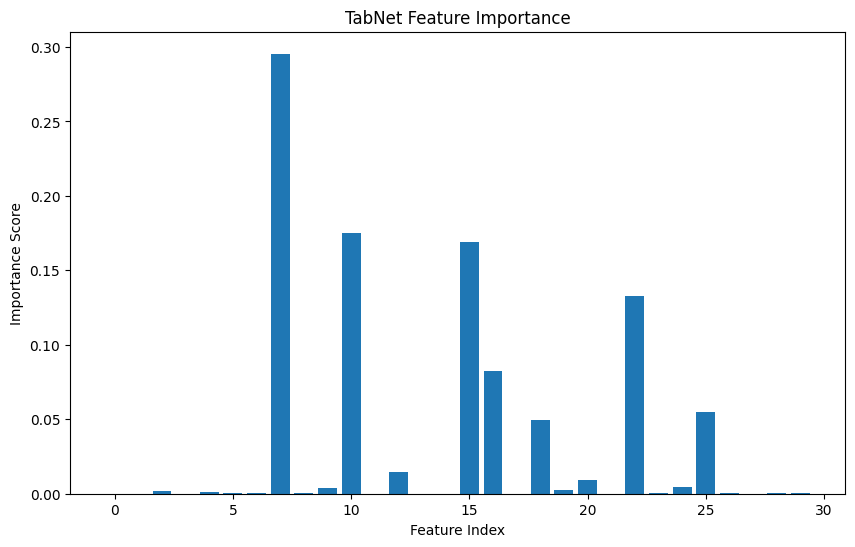

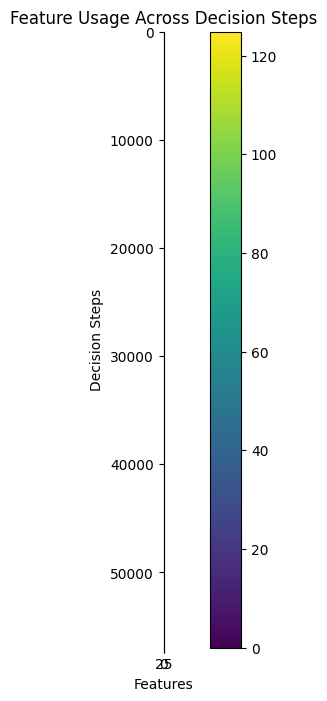

In [6]:
# Get feature importance
feature_importance = clf.feature_importances_

# Get feature masks for specific decisions
masks = clf.explain(X_test.values)

# Visualize overall importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('TabNet Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.show()

# Visualize decision-specific masks
plt.figure(figsize=(12, 8))
plt.imshow(masks[0])  # First sample
plt.title('Feature Usage Across Decision Steps')
plt.xlabel('Features')
plt.ylabel('Decision Steps')
plt.colorbar()
plt.show()

## Explain individual predictions

True Label: Fraud
Predicted Label: Fraud
Fraud Probability: 1.000


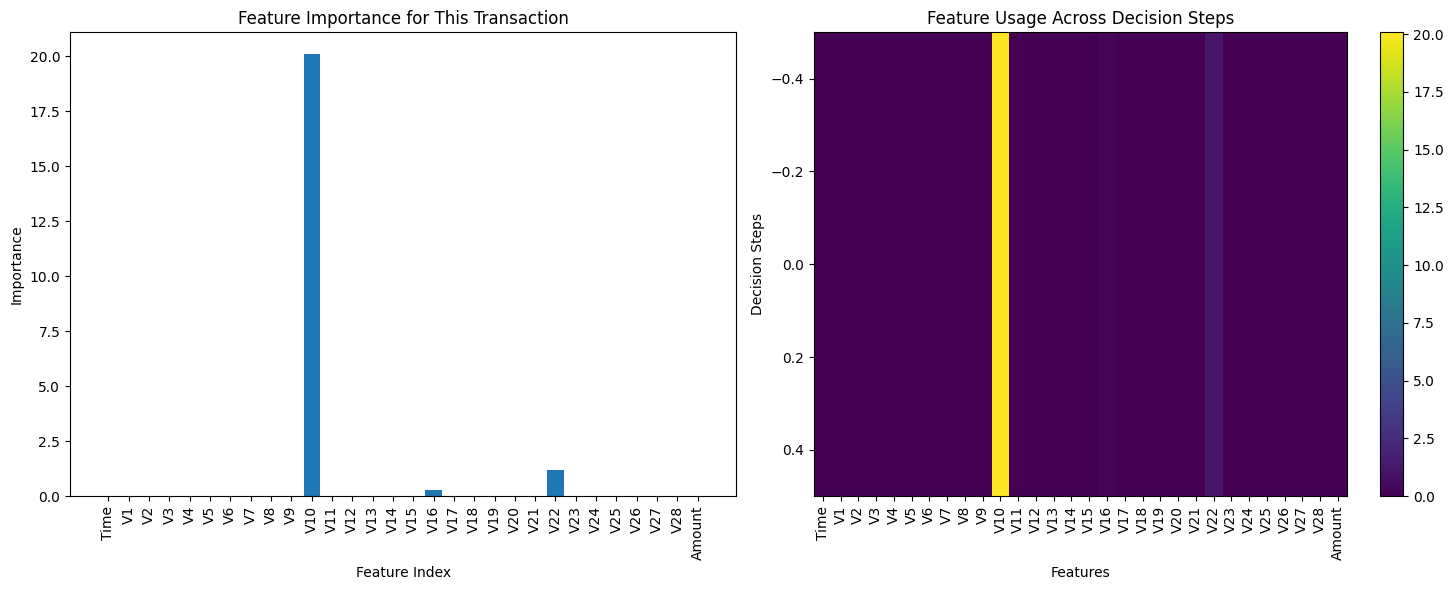


Top 5 Most Important Features for this Decision:
Feature V10: 20.078
Feature V22: 1.195
Feature V16: 0.285
Feature V27: 0.000
Feature Amount: 0.000

Feature Values Comparison:

Feature V10:
  Value: -14.110
  Average: -0.001
  Z-score: -12.984

Feature V22:
  Value: -1.128
  Average: -0.001
  Z-score: -1.553

Feature V16:
  Value: -9.899
  Average: 0.001
  Z-score: -11.283

Feature V27:
  Value: -2.019
  Average: -0.000
  Z-score: -5.024

Feature Amount:
  Value: 364.190
  Average: 88.480
  Z-score: 1.082


In [7]:
# Pick a fraud case from test set
fraud_indices = np.where(y_test == 1)[0]
sample_idx = fraud_indices[0]  # First fraud case

# Get the sample data
sample = X_test.values[sample_idx:sample_idx+1]
true_label = y_test.iloc[sample_idx]

# Get prediction and probability for this case
pred = clf.predict(sample)
pred_proba = clf.predict_proba(sample)

# Get instance-wise feature importance
masks = clf.explain(sample)

# Print basic information
print(f"True Label: {'Fraud' if true_label == 1 else 'Normal'}")
print(f"Predicted Label: {'Fraud' if pred[0] == 1 else 'Normal'}")
print(f"Fraud Probability: {pred_proba[0][1]:.3f}")

# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Convert X_train to numpy if it's not already
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train

# Visualize feature importance for this instance
plt.figure(figsize=(15, 6))

# Plot 1: Overall feature importance for this instance
plt.subplot(1, 2, 1)
instance_importance = masks[0].sum(axis=0)  # Sum across decision steps
plt.bar(range(len(instance_importance)), instance_importance)
plt.title('Feature Importance for This Transaction')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation=90)

# Plot 2: Feature usage across decision steps
plt.subplot(1, 2, 2)
plt.imshow(masks[0], aspect='auto')
plt.title('Feature Usage Across Decision Steps')
plt.xlabel('Features')
plt.ylabel('Decision Steps')
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.colorbar()

plt.tight_layout()
plt.show()

# Print top 5 most important features for this decision
top_features = np.argsort(instance_importance)[-5:][::-1]
print("\nTop 5 Most Important Features for this Decision:")
for idx in top_features:
    print(f"Feature {feature_names[idx]}: {instance_importance[idx]:.3f}")

# Compare feature values with average values
print("\nFeature Values Comparison:")
for idx in top_features:
    feature_name = feature_names[idx]
    sample_value = sample[0][idx]
    avg_value = X_train_np[:, idx].mean()
    std_value = X_train_np[:, idx].std()
    z_score = (sample_value - avg_value) / std_value
    
    print(f"\nFeature {feature_name}:")
    print(f"  Value: {sample_value:.3f}")
    print(f"  Average: {avg_value:.3f}")
    print(f"  Z-score: {z_score:.3f}")